<a href="https://colab.research.google.com/github/shivnag5/BA888-Exercise/blob/main/Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Identify states with the highest inbound migration in terms of both absolute numbers and relative to their population.

- Determine states with the highest outbound migration, again in terms of absolute numbers and relative to their population.

- Visualize the net flux of migrants per state on a map.

- Identify the pair of states with the highest share in the overall migration trend.

- Represent interstate migration clearly using a graph.

In [4]:
import pandas as pd

file_path = "/State_to_State_Migration_Table_2023_T13.xlsx"
xls = pd.ExcelFile(file_path)

In [7]:
# Cleaning
df_clean = pd.read_excel(xls, sheet_name="Table", skiprows=5)

df_clean.rename(columns={df_clean.columns[0]: "Current_Residence"}, inplace=True)

df_clean.dropna(subset=["Current_Residence"], inplace=True)

In [8]:
df_states = df_clean[[
    "Current_Residence",
    "Unnamed: 1",  # Total population
    "Different state of residence 1 year ago"  # Inbound migration
]]

In [9]:
df_states.columns = ["State", "Population", "Inbound_Migration"]

In [12]:
df_states = df_states[~df_states["State"].str.contains("United States|Puerto Rico|Island", na=False)]
df_states["Population"] = pd.to_numeric(df_states["Population"], errors='coerce')
df_states["Inbound_Migration"] = pd.to_numeric(df_states["Inbound_Migration"], errors='coerce')

# Extract outbound migration from state-to-state matrix
from_cols = df_clean.columns[9:59]
to_states = df_clean["Current_Residence"].iloc[5:55].tolist()

# Filter outbound matrix data
outbound_data = df_clean.loc[df_clean["Current_Residence"].isin(to_states), ["Current_Residence"] + list(from_cols)]
outbound_data.columns = ["State"] + to_states

# Sum across rows to get total outbound migration
outbound_data["Outbound_Migration"] = outbound_data[to_states].apply(pd.to_numeric, errors='coerce').sum(axis=1)

# Merge inbound and outbound migration data
df_states = df_states.merge(outbound_data[["State", "Outbound_Migration"]], on="State")

# Calculate relative values and net migration
df_states["Inbound_per_1000"] = df_states["Inbound_Migration"] / df_states["Population"] * 1000
df_states["Outbound_per_1000"] = df_states["Outbound_Migration"] / df_states["Population"] * 1000
df_states["Net_Migration"] = df_states["Inbound_Migration"] - df_states["Outbound_Migration"]

In [15]:
print(df_states.sort_values(by="Inbound_Migration", ascending=False).head(5))
print(df_states.sort_values(by="Outbound_Migration", ascending=False).head(5))
print(df_states.sort_values(by="Net_Migration", ascending=False).head(5))

             State  Population  Inbound_Migration  Outbound_Migration_x  \
5          Florida  22395466.0           636933.0              372514.0   
38           Texas  30134547.0           611942.0              459211.0   
0       California  38552167.0           422075.0              218985.0   
29  North Carolina  10719307.0           339255.0              219329.0   
6          Georgia  10909651.0           310452.0              204327.0   

    Inbound_per_1000  Outbound_per_1000  Net_Migration  Outbound_Migration_y  \
5          28.440266          16.633456       264419.0              372514.0   
38         20.306992          15.238689       152731.0              459211.0   
0          10.948152           5.680225       203090.0              218985.0   
29         31.648968          20.461117       119926.0              219329.0   
6          28.456639          18.729013       106125.0              204327.0   

    Outbound_Migration  
5             372514.0  
38            4592

<ipython-input-17-6b32be596758>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


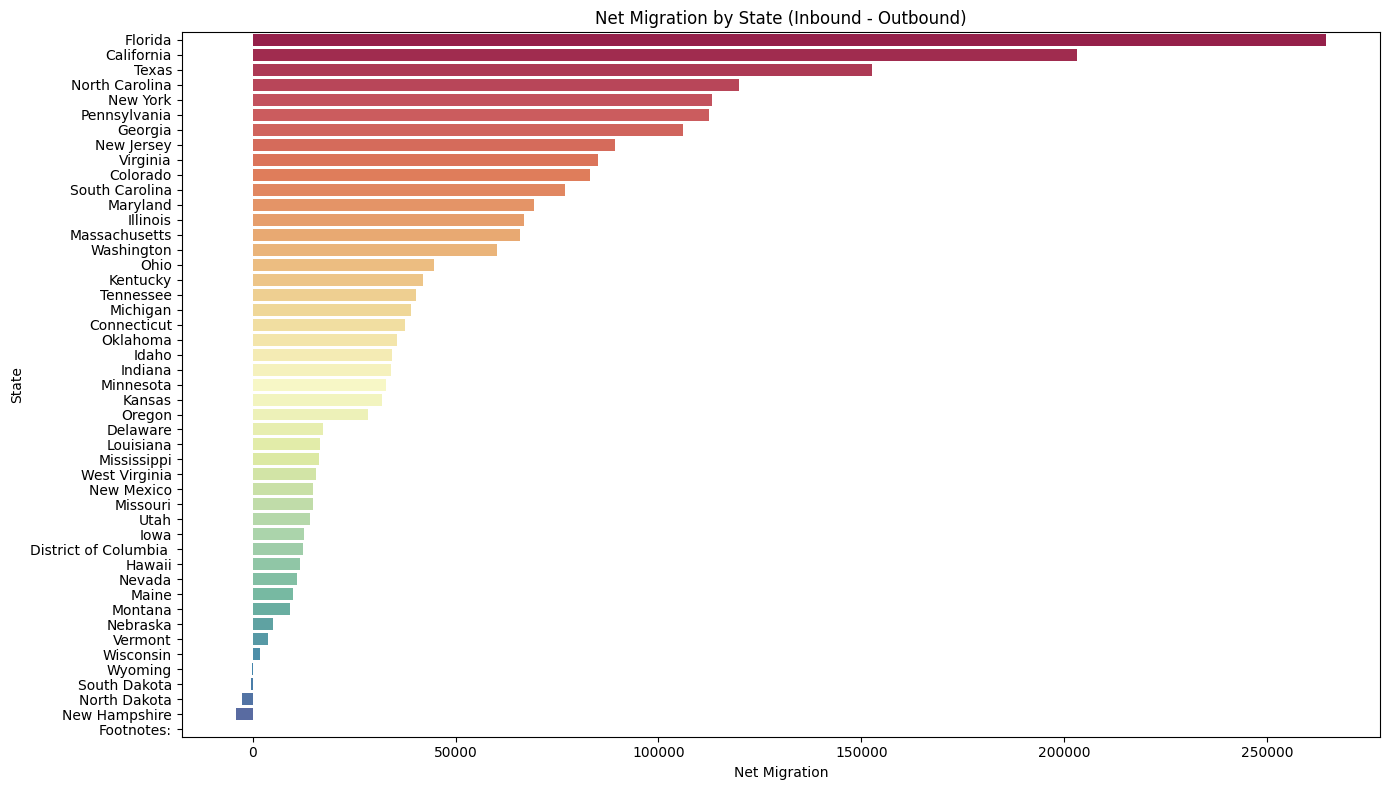

<ipython-input-17-6b32be596758>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_flows, x="Migrants", y=top_flows["From_State"] + " → " + top_flows["To_State"], palette="coolwarm")


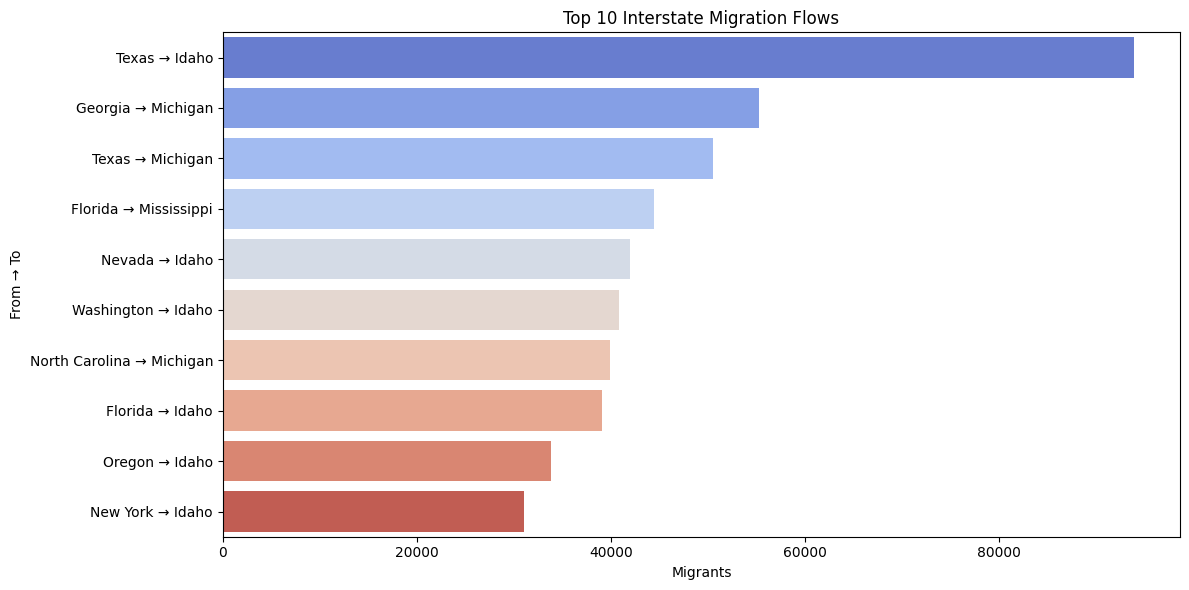

,From_State,To_State,Migrants
1916,Texas,Idaho,93970.0


In [17]:
# Skip the GeoPandas map due to environment limitation and focus on seaborn visualizations

import matplotlib.pyplot as plt
import seaborn as sns

# Barplot of net migration
plt.figure(figsize=(14, 8))
sns.barplot(
    data=df_states.sort_values(by="Net_Migration", ascending=False),
    x="Net_Migration",
    y="State",
    palette="Spectral"
)
plt.title("Net Migration by State (Inbound - Outbound)")
plt.xlabel("Net Migration")
plt.ylabel("State")
plt.tight_layout()
plt.show()

# Now find the pair of states with the highest individual flow
# Re-extract the matrix of state-to-state migration flows
flow_matrix = df_clean.loc[df_clean["Current_Residence"].isin(to_states), ["Current_Residence"] + list(from_cols)]
flow_matrix.columns = ["From_State"] + to_states
flow_matrix = flow_matrix.set_index("From_State")
flow_matrix = flow_matrix.apply(pd.to_numeric, errors='coerce')

# Unpivot to long format
flow_long = flow_matrix.stack().reset_index()
flow_long.columns = ["From_State", "To_State", "Migrants"]
flow_long = flow_long[flow_long["From_State"] != flow_long["To_State"]]  # remove self-migration

# Get top migration pair
top_pair = flow_long.sort_values(by="Migrants", ascending=False).head(1)

# Plot top 10 migration flows
top_flows = flow_long.sort_values(by="Migrants", ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_flows, x="Migrants", y=top_flows["From_State"] + " → " + top_flows["To_State"], palette="coolwarm")
plt.title("Top 10 Interstate Migration Flows")
plt.xlabel("Migrants")
plt.ylabel("From → To")
plt.tight_layout()
plt.show()

top_pair
